# Fitting a Gradient Boosting Machine (GBM) and publishing to AzureML using R

## Summary

Fit a Gradient Boosting Machine (GBM) model using R, and then publish the model as a web service on the Azure ML Studio.

## Description

GBM is well-known among data scientists and as a [Kaggler][kaggle link] explains, it has several major advantages compared with traditional statistical models like linear regression:

* it automatically approximates non-linear transformations and interactions
* it treats missing values without having to fill in values or remove observations
* monotonic transformation of features won't influence the model's performance

For users who are used to fitting GBM models in Azure ML Experiments, a big advantage of using Azure ML notebooks is that you have many modeling options. For example, when the response variable is continuous you can use the "Boosted Decision Tree Regression" module in Azure ML Experiments to fit a GBM model.

However, this module does not you to specify the type of loss functions (for statisticians, this means that you can't specify the distribution for the response variable).

In contrast, using the `gbm` package in R, you can choose from a wide variety of loss functions.

[kaggle link]: http://blog.kaggle.com/2015/06/22/profiling-top-kagglers-owen-zhang-currently-1-in-the-world

## Data

In this example, you use the housing data from the R package `MASS`. There are 506 rows and 14 columns in the dataset. Available information includes median home price, average number of rooms per dwelling, crime rate by town, etc. More information about this dataset can be found by typing `?Boston` or `help(Boston)` in an R terminal, or at this [UCI page][uci link].

[uci link]: https://archive.ics.uci.edu/ml/datasets/Housing

In [1]:
library(MASS) # to use the Boston dataset
?Boston

Boston {MASS},R Documentation


## GBM model
### Estimate hyperparameters
In a GBM model, there are several hyperparameters and we need to estimate them first. One way to estimate these parameters is to use cross validation on a parameter-grid. In our example, we'll optimize the following parameters over a grid: number of estimators, maximum tree depth, minimum number of samples on a split, and learning rate. To do this we start by providing several values for each of them and create a set of combinations, each combination consisting of one value for each parameter. Then for each combination we use cross validation to estimate the performance, using root mean squared error as performance metric. The "caret" package will be used in this process.

We start by installing necessary packages if they are not already installed. 

It may take a while to finish.

In [2]:
# load the libraries
if(!require("gbm")) install.packages("gbm")
library(gbm) # to fit gbm model
if(!require("caret")) install.packages("caret")
library(caret) # to estimate hyperparameters

Loading required package: gbm
Loading required package: survival
Loading required package: splines
Loading required package: lattice
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: caret
Loading required package: ggplot2

Attaching package: 'caret'

The following object is masked from 'package:survival':

    cluster



Running the following block will take some time. You can test the code by reducing the size of the grid. 

In [3]:
# prepare training scheme
control <- trainControl(method = "cv", number = 5)

# design the parameter tuning grid 
grid <- expand.grid(n.trees = c(5000, 10000), 
                    interaction.depth = c(2, 4), 
                    n.minobsinnode = c(1, 2), 
                    shrinkage = c(0.001, 0.01))
# tune the parameters
model1 <- train(medv ~ ., data = Boston, method="gbm", distribution = "gaussian",
              trControl = control, verbose = FALSE, tuneGrid = grid, metric = "RMSE")

Loading required package: plyr


In [4]:
# check the final values
model1$bestTune
n_trees <- model1$bestTune$n.trees
interaction_depth <- model1$bestTune$interaction.depth
shrinkage <- model1$bestTune$shrinkage
n_minobsinnode <-model1$bestTune$n.minobsinnode

# summarize the model
# print(model1)

,n.trees,interaction.depth,shrinkage,n.minobsinnode
13,5000,4,0.01,1


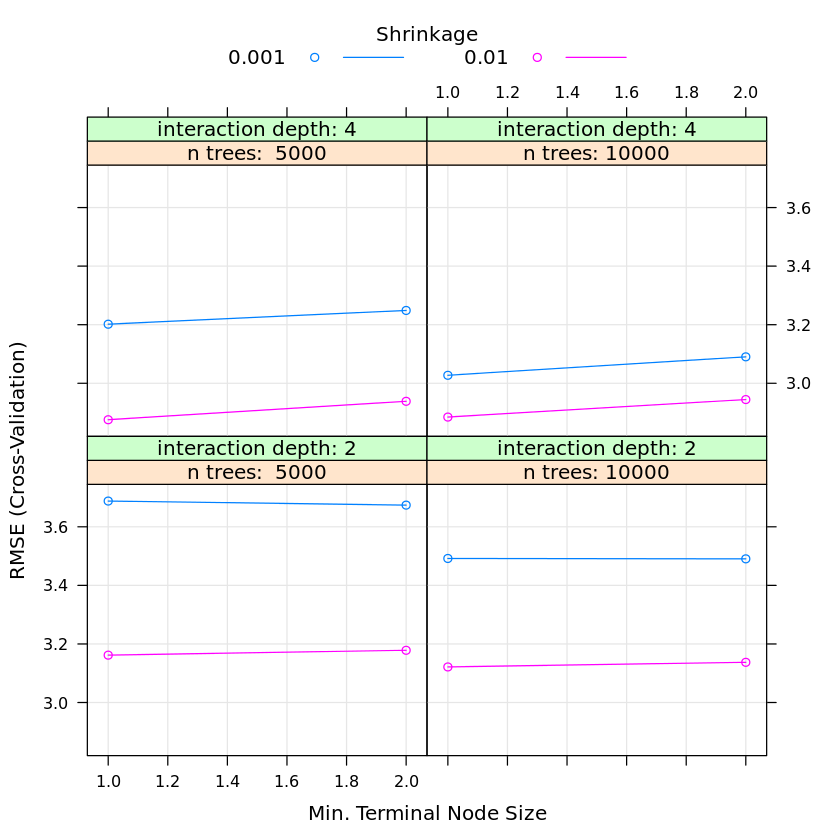

In [5]:
# plot cv results
plot(model1)

### Fit Model with Estimated Parameters
With the selected parameter values from above, we can fit a GBM model.

In [6]:
# fit the model
model2 <- gbm(medv ~ ., data = Boston, 
            distribution = "gaussian",
            n.trees = n_trees,
            interaction.depth = interaction_depth, 
            n.minobsinnode = n_minobsinnode, 
            shrinkage = shrinkage,
            cv.folds = 5)

# print model
print(model2) 
# summary
# summary(model2)

gbm(formula = medv ~ ., distribution = "gaussian", data = Boston, 
    n.trees = n_trees, interaction.depth = interaction_depth, 
    n.minobsinnode = n_minobsinnode, shrinkage = shrinkage, cv.folds = 5)
A gradient boosted model with gaussian loss function.
5000 iterations were performed.
The best cross-validation iteration was 4521.
There were 13 predictors of which 13 had non-zero influence.


For the fitted model,we can look closely at how the number of trees affect loss function on training and validation data to select the best value.

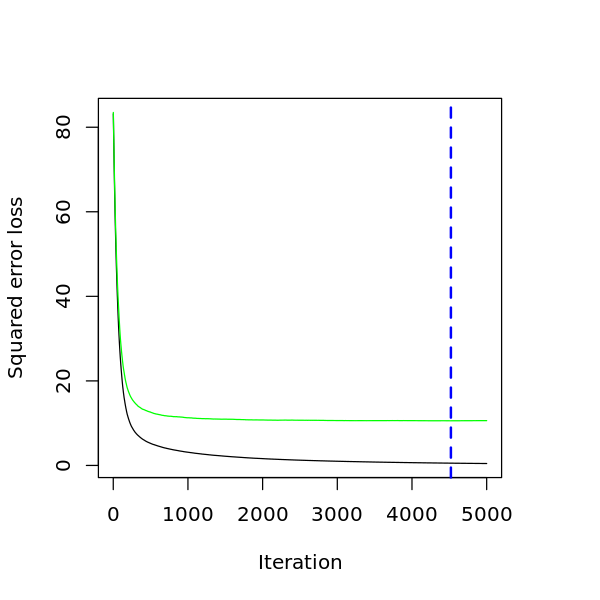

In [7]:
# check performance using 5-fold cross-validation
options(repr.plot.width = 5, repr.plot.height = 5)
best.iter <- gbm.perf(model2,method="cv")

A plot comparing the importance of variables is generated with the following code. 

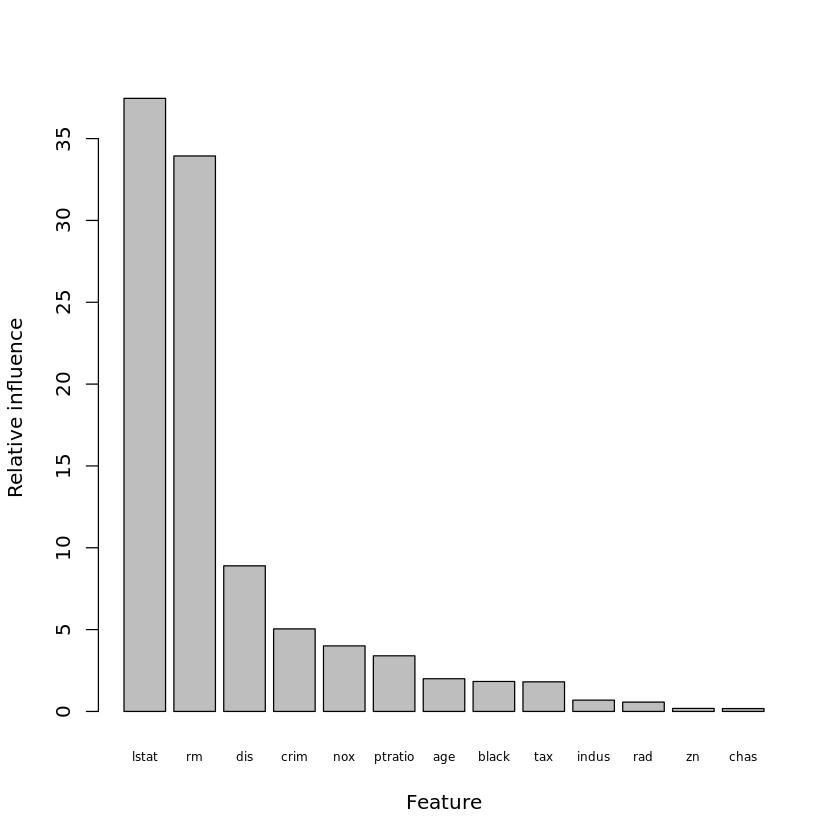

In [8]:
options(repr.plot.width = 7, repr.plot.height = 7)
# check variable importance
f_imp <- summary(model2, n.trees = best.iter, plot = FALSE) 
# use a custom plot to show variable importance
barplot(f_imp$rel.inf, names.arg = f_imp$var, xlab = "Feature", ylab = "Relative influence", cex.names = 0.6)

## Web service

### Deploy a web service

With the developed model, we can deploy a web service so that others can use it to make predictions. You can use the `AzureML` package for this purpose. 

**Important: Publishing and consuming a web service requires you to have valid Azure ML credentials. Concretely, if you logged in using a Guest account, you will get an error. If this is the case, please log in using your Microsoft or Azure account and try again.**

In [9]:
# load the library
library(AzureML)

# If you use workspace() in a Jupyter notebook, you don't need to specify credentials,
# since the settings are stored for you in a local file.
# If you use this function on your own machine, specify your credentials. See ?workspace.

if(file.exists("~/.azureml/settings.json")){
    ws <- workspace()
} else {
    # workspace_id <- ""
    # authorization_token <- ""
    ws <- workspace(workspace_id, authorization_token)
}

# define predict function
predict_gbm <- function(newdata){
  require(gbm)
  predict(model2, newdata, n.trees = 1000)
}

# test the prediction function
newdata <- Boston[1:10, ]
pred <- predict_gbm(newdata)

data.frame(actual = newdata$medv, prediction = pred)

,actual,prediction
1,24,26.00636
2,21.6,21.68276
3,34.7,34.75097
4,33.4,35.07404
5,36.2,34.23642
6,28.7,26.36661
7,22.9,21.37939
8,27.1,20.82221
9,16.5,16.30509
10,18.9,18.43094


In [10]:
# Publish the service
ep <- publishWebService(ws = ws, fun = predict_gbm, 
                        name = "HousePricePredictionGBM", 
                        inputSchema = newdata)
# str(ep)

### Consume a web service

With information about the workspace and and service ID, we can consume the web service with the following code.

**Important: Publishing and consuming a web service requires you to have valid Azure ML credentials. Concretely, if you logged in using a Guest account, you will get an error. If this is the case, please log in using your Microsoft or Azure account and try again.**

In [11]:
newdata <- Boston
pred <- consume(ep, newdata)$ans
# Note that it can take some time for the published web service to be ready in Azure ML Studio
# The consume() function will retry several times to reach the service

Request failed with status 401. Waiting 3.1 seconds before retry
....

In [12]:
predictions <- data.frame(actual = newdata$medv, prediction = pred)
head(predictions)

,actual,prediction
1,24,26.00636
2,21.6,21.68276
3,34.7,34.75097
4,33.4,35.07404
5,36.2,34.23642
6,28.7,26.36661


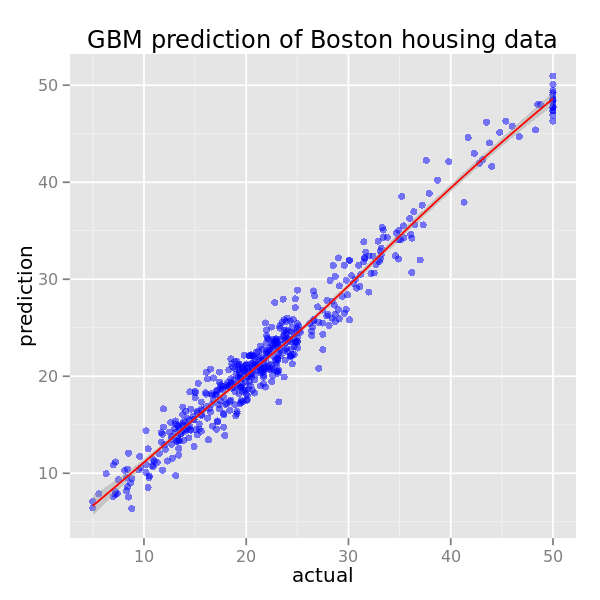

In [13]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(predictions, aes(x = actual, y = prediction)) + 
    geom_point(colour = "blue", alpha = 0.5) +
    stat_smooth(colour = "red") + 
    ggtitle("GBM prediction of Boston housing data")

The GBM model seems to fit the data really well, giving close predictions on the entire range of input data.

## Conclusion

Using the `Boston` housing dataset, we started the analysis by estimating the parameters in the GBM model. Then we fitted the model and examined variable importance. A web service was also deployed based on the selected model.

In addition to the **gaussian** distribution that uses squared error loss function, the `gbm` package allows for several other distributions. These include **laplace** that uses absolute loss and **t-distribution** that uses t-distribution loss, among others.

The `caret` package makes it possible to easily tune the hyperparameters on a grid. 